# Deep Learning Lab Assignment 6
    
    Ayush Abrol B20AI052
---

In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.profiler 
import torch.utils.data 
import torchvision.datasets
import torchvision.models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from time import perf_counter
from copy import deepcopy
import torch.onnx
import tensorboard
import warnings
warnings.filterwarnings('ignore')

c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading and preprocessing CIFAR100 dataset using standard augmentation and normalization techniques

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
batch_size = 128
epochs = 50
lr = 1e-3

In [6]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(trainset.data.shape)
print(testset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [8]:
print(len(trainset.classes))

100


Displaying a subset with 100 images from the training set:


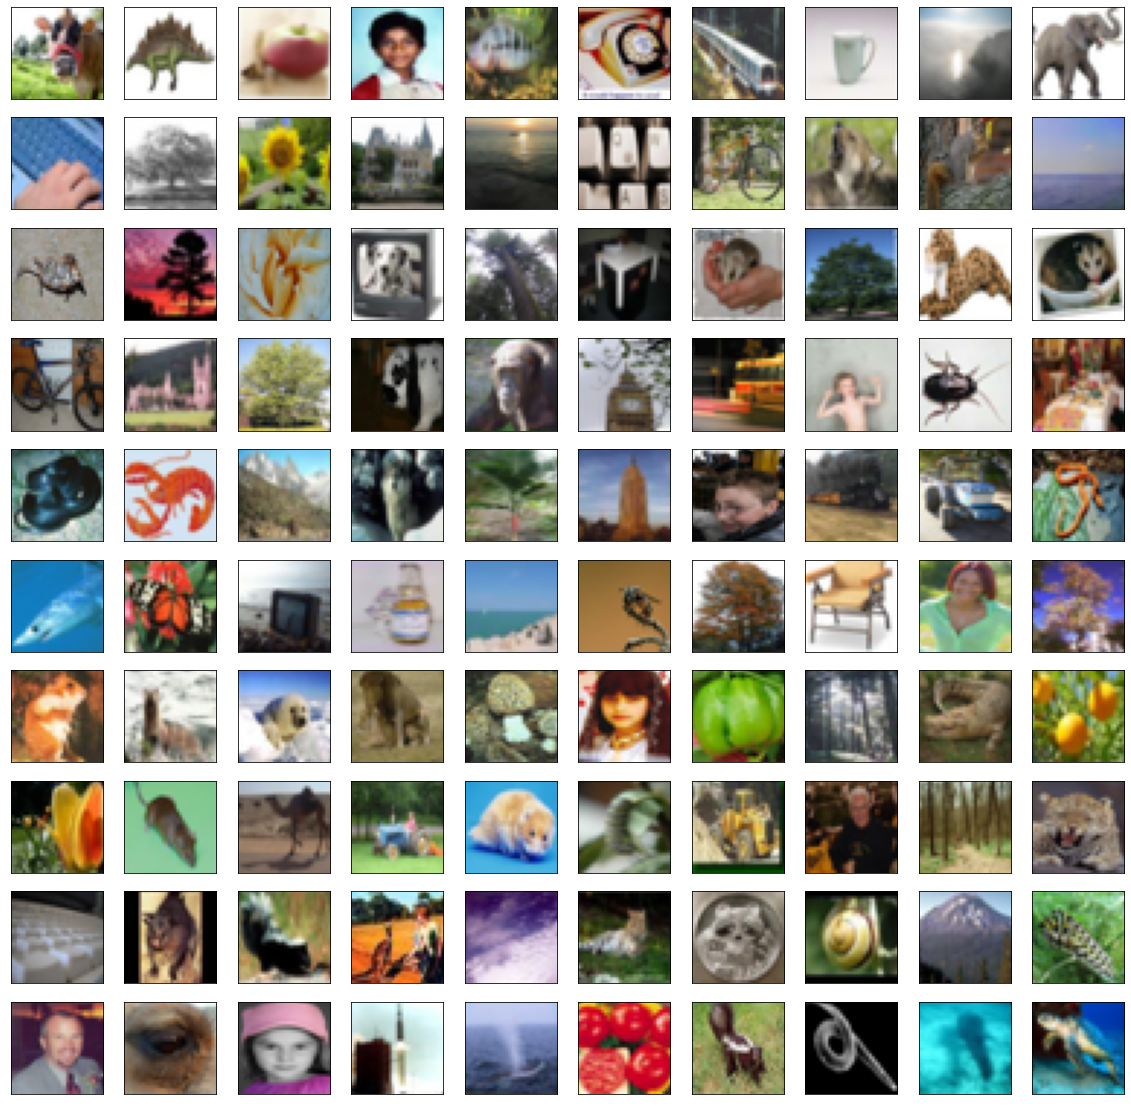

In [8]:
print("Displaying a subset with 100 images from the training set:")
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainset.data[i])
    plt.xlabel(trainset.classes[trainset.targets[i]], color='white')
plt.show()

### Train the following models for 50 epoch and at the same time profile the model using Tensorboard during the training step
    ○ ResNet-34
    ○ DenseNet-121
    ○ EfficientNet-B0
    ○ ConvNeXt-T

In [9]:
resnet34 = torchvision.models.resnet34(pretrained=True).to(device)
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
densenet121 = torchvision.models.densenet121(pretrained=True).to(device)
densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [11]:
efficientnet_b0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
efficientnet_b0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
convnext = torchvision.models.convnext_tiny(pretrained=True).to(device)
convnext

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

### Fine-tuning the models for CIFAR-100

In [13]:
resnet34.fc = nn.Linear(512, 100).to(device)
densenet121.classifier = nn.Linear(1024, 100).to(device)
efficientnet_b0._fc = nn.Linear(1280, 100).to(device)
convnext.fc = nn.Linear(768, 100).to(device)

### Defining the loss function and optimizers for the models

In [14]:
criteria = nn.CrossEntropyLoss()
optimizer_resnet34 = optim.Adam(resnet34.parameters(), lr=lr)
optimizer_densenet121 = optim.Adam(densenet121.parameters(), lr=lr)
optimizer_efficientnet_b0 = optim.Adam(efficientnet_b0.parameters(), lr=lr)
optimizer_convnext = optim.Adam(convnext.parameters(), lr=lr)

In [15]:
def train(model, trainloader, epochs, optimizer, criterion, train_loss, train_accuracy):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_correct = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_correct += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = running_correct.double() / len(trainloader.dataset)
        print('Epoch {}/{} - Loss: {:.4f} - Acc: {:.4f}'.format(epoch+1, epochs, epoch_loss, epoch_acc))
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)
    return model, train_loss, train_accuracy

In [16]:
def profiler(model, trainloader, epochs, optimizer, criterion, writer, loss_list, accuracy_list):
    with torch.profiler.profile(
          schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
          on_trace_ready=torch.profiler.tensorboard_trace_handler(writer),
          record_shapes=True,
          profile_memory=True,
          with_stack=True
  ) as prof:
        model, loss_list, accuracy_list = train(model, trainloader, epochs, optimizer, criterion, loss_list, accuracy_list)
        prof.step()
    return model, loss_list, accuracy_list

In [17]:
writer_resnet34 = './logs/resnet34'
writer_densenet121 = './logs/densenet121'
writer_efficientnet_b0 = './logs/efficientnet_b0'
writer_convnext = './logs/convnext'

In [18]:
train_loss_resnet34 = []
train_accuracy_resnet34 = []
train_loss_densenet121 = []
train_accuracy_densenet121 = []
train_loss_efficientnet_b0 = []
train_accuracy_efficientnet_b0 = []
train_loss_convnext = []
train_accuracy_convnext = []

In [23]:
resnet34, train_loss_resnet34, train_accuracy_resnet34 = profiler(resnet34, trainloader, epochs, optimizer_resnet34, criteria, writer_resnet34, train_loss_resnet34, train_accuracy_resnet34)

Epoch 1/50 - Loss: 1.0487 - Acc: 0.6846
Epoch 2/50 - Loss: 1.0337 - Acc: 0.6905
Epoch 3/50 - Loss: 0.9354 - Acc: 0.7152
Epoch 4/50 - Loss: 0.9521 - Acc: 0.7095
Epoch 5/50 - Loss: 0.9538 - Acc: 0.7120
Epoch 6/50 - Loss: 0.8133 - Acc: 0.7484
Epoch 7/50 - Loss: 0.7726 - Acc: 0.7597
Epoch 8/50 - Loss: 0.7308 - Acc: 0.7721
Epoch 9/50 - Loss: 0.6970 - Acc: 0.7810
Epoch 10/50 - Loss: 0.6469 - Acc: 0.7976
Epoch 11/50 - Loss: 0.5937 - Acc: 0.8116
Epoch 12/50 - Loss: 0.5771 - Acc: 0.8173
Epoch 13/50 - Loss: 0.6622 - Acc: 0.7930
Epoch 14/50 - Loss: 0.7606 - Acc: 0.7666
Epoch 15/50 - Loss: 0.5306 - Acc: 0.8315
Epoch 16/50 - Loss: 0.5034 - Acc: 0.8390
Epoch 17/50 - Loss: 0.5448 - Acc: 0.8297
Epoch 18/50 - Loss: 0.4798 - Acc: 0.8468
Epoch 19/50 - Loss: 0.3971 - Acc: 0.8718
Epoch 20/50 - Loss: 0.3996 - Acc: 0.8719
Epoch 21/50 - Loss: 0.4045 - Acc: 0.8698
Epoch 22/50 - Loss: 0.3513 - Acc: 0.8842
Epoch 23/50 - Loss: 0.3549 - Acc: 0.8845
Epoch 24/50 - Loss: 0.3315 - Acc: 0.8910
Epoch 25/50 - Loss: 0.334

In [24]:
densenet121, train_loss_densenet121, train_accuracy_densenet121 = profiler(densenet121, trainloader, epochs, optimizer_densenet121, criteria, writer_densenet121, train_loss_densenet121, train_accuracy_densenet121)

Epoch 1/50 - Loss: 2.7529 - Acc: 0.3088
Epoch 2/50 - Loss: 1.9227 - Acc: 0.4752
Epoch 3/50 - Loss: 1.6546 - Acc: 0.5369
Epoch 4/50 - Loss: 1.4896 - Acc: 0.5771
Epoch 5/50 - Loss: 1.3621 - Acc: 0.6079
Epoch 6/50 - Loss: 1.2672 - Acc: 0.6295
Epoch 7/50 - Loss: 1.1766 - Acc: 0.6519
Epoch 8/50 - Loss: 1.0931 - Acc: 0.6754
Epoch 9/50 - Loss: 1.0299 - Acc: 0.6893
Epoch 10/50 - Loss: 0.9515 - Acc: 0.7106
Epoch 11/50 - Loss: 0.8955 - Acc: 0.7252
Epoch 12/50 - Loss: 0.8424 - Acc: 0.7412
Epoch 13/50 - Loss: 0.7801 - Acc: 0.7576
Epoch 14/50 - Loss: 0.7315 - Acc: 0.7720
Epoch 15/50 - Loss: 0.6819 - Acc: 0.7871
Epoch 16/50 - Loss: 0.6287 - Acc: 0.7996
Epoch 17/50 - Loss: 0.5989 - Acc: 0.8085
Epoch 18/50 - Loss: 0.5672 - Acc: 0.8175
Epoch 19/50 - Loss: 0.5310 - Acc: 0.8283
Epoch 20/50 - Loss: 0.4946 - Acc: 0.8395
Epoch 21/50 - Loss: 0.4657 - Acc: 0.8485
Epoch 22/50 - Loss: 0.4375 - Acc: 0.8568
Epoch 23/50 - Loss: 0.4192 - Acc: 0.8623
Epoch 24/50 - Loss: 0.3993 - Acc: 0.8686
Epoch 25/50 - Loss: 0.368

In [25]:
efficientnet_b0, train_loss_efficientnet_b0, train_accuracy_efficientnet_b0 = profiler(efficientnet_b0, trainloader, epochs, optimizer_efficientnet_b0, criteria, writer_efficientnet_b0, train_loss_efficientnet_b0, train_accuracy_efficientnet_b0)

Epoch 1/50 - Loss: 4.0666 - Acc: 0.1273
Epoch 2/50 - Loss: 2.4801 - Acc: 0.3545
Epoch 3/50 - Loss: 2.0345 - Acc: 0.4545
Epoch 4/50 - Loss: 1.8057 - Acc: 0.5038
Epoch 5/50 - Loss: 1.6496 - Acc: 0.5432
Epoch 6/50 - Loss: 1.5630 - Acc: 0.5617
Epoch 7/50 - Loss: 1.4762 - Acc: 0.5794
Epoch 8/50 - Loss: 1.3681 - Acc: 0.6069
Epoch 9/50 - Loss: 1.3749 - Acc: 0.6064
Epoch 10/50 - Loss: 1.2956 - Acc: 0.6279
Epoch 11/50 - Loss: 1.2017 - Acc: 0.6504
Epoch 12/50 - Loss: 1.1464 - Acc: 0.6612
Epoch 13/50 - Loss: 1.1232 - Acc: 0.6678
Epoch 14/50 - Loss: 1.0445 - Acc: 0.6885
Epoch 15/50 - Loss: 1.0299 - Acc: 0.6936
Epoch 16/50 - Loss: 0.9374 - Acc: 0.7161
Epoch 17/50 - Loss: 0.9073 - Acc: 0.7247
Epoch 18/50 - Loss: 0.9980 - Acc: 0.7031
Epoch 19/50 - Loss: 1.0875 - Acc: 0.6827
Epoch 20/50 - Loss: 0.9693 - Acc: 0.7122
Epoch 21/50 - Loss: 0.9868 - Acc: 0.7066
Epoch 22/50 - Loss: 0.8903 - Acc: 0.7306
Epoch 23/50 - Loss: 0.8314 - Acc: 0.7463
Epoch 24/50 - Loss: 0.7939 - Acc: 0.7583
Epoch 25/50 - Loss: 0.881

In [26]:
convnext, train_loss_convnext, train_accuracy_convnext = profiler(convnext, trainloader, epochs, optimizer_convnext, criteria, writer_convnext, train_loss_convnext, train_accuracy_convnext)

Epoch 1/50 - Loss: 2.3223 - Acc: 0.4038
Epoch 2/50 - Loss: 1.5103 - Acc: 0.5729
Epoch 3/50 - Loss: 1.2895 - Acc: 0.6284
Epoch 4/50 - Loss: 1.1403 - Acc: 0.6650
Epoch 5/50 - Loss: 1.0173 - Acc: 0.6975
Epoch 6/50 - Loss: 0.9048 - Acc: 0.7268
Epoch 7/50 - Loss: 0.8194 - Acc: 0.7477
Epoch 8/50 - Loss: 0.7287 - Acc: 0.7734
Epoch 9/50 - Loss: 0.6506 - Acc: 0.7960
Epoch 10/50 - Loss: 0.5864 - Acc: 0.8141
Epoch 11/50 - Loss: 0.5256 - Acc: 0.8320
Epoch 12/50 - Loss: 0.4719 - Acc: 0.8484
Epoch 13/50 - Loss: 0.4227 - Acc: 0.8642
Epoch 14/50 - Loss: 0.3864 - Acc: 0.8748
Epoch 15/50 - Loss: 0.3502 - Acc: 0.8862
Epoch 16/50 - Loss: 0.3384 - Acc: 0.8902
Epoch 17/50 - Loss: 0.3040 - Acc: 0.9020
Epoch 18/50 - Loss: 0.2868 - Acc: 0.9065
Epoch 19/50 - Loss: 0.2630 - Acc: 0.9144
Epoch 20/50 - Loss: 0.2546 - Acc: 0.9158
Epoch 21/50 - Loss: 0.2381 - Acc: 0.9230
Epoch 22/50 - Loss: 0.2293 - Acc: 0.9256
Epoch 23/50 - Loss: 0.2163 - Acc: 0.9306
Epoch 24/50 - Loss: 0.2084 - Acc: 0.9329
Epoch 25/50 - Loss: 0.196

In [27]:
# Saving the trained models
torch.save(resnet34.state_dict(), './models/resnet34.pth')
torch.save(densenet121.state_dict(), './models/densenet121.pth')
torch.save(efficientnet_b0.state_dict(), './models/efficientnet_b0.pth')
torch.save(convnext.state_dict(), './models/convnext.pth')

In [19]:
# Loading the trained models
resnet34.load_state_dict(torch.load('./models/resnet34.pth'))
densenet121.load_state_dict(torch.load('./models/densenet121.pth'))
efficientnet_b0.load_state_dict(torch.load('./models/efficientnet_b0.pth'))
convnext.load_state_dict(torch.load('./models/convnext.pth'))

<All keys matched successfully>

In [20]:
def timer(f,*args):   
    start = perf_counter()
    f(*args)
    return (1000 * (perf_counter() - start))

In [47]:
for i in range(len(train_accuracy_resnet34)):
    train_accuracy_resnet34[i] = train_accuracy_resnet34[i].cpu().numpy()

for i in range(len(train_accuracy_densenet121)):
    train_accuracy_densenet121[i] = train_accuracy_densenet121[i].cpu().numpy()

for i in range(len(train_accuracy_efficientnet_b0)):
    train_accuracy_efficientnet_b0[i] = train_accuracy_efficientnet_b0[i].cpu().numpy()

for i in range(len(train_accuracy_convnext)):
    train_accuracy_convnext[i] = train_accuracy_convnext[i].cpu().numpy()

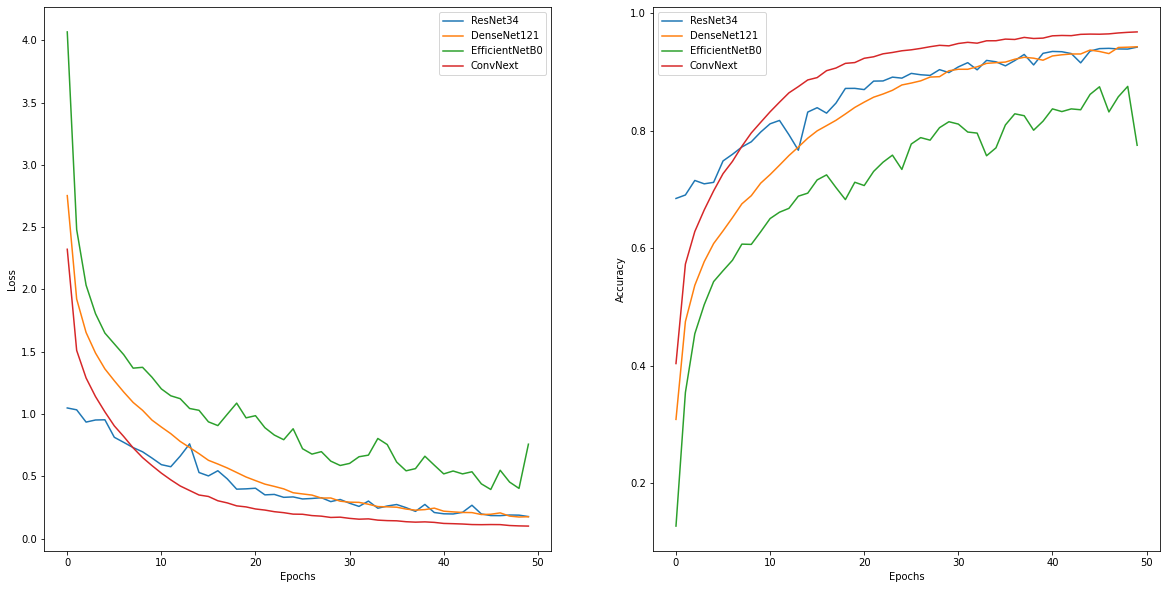

In [22]:
# Plotting the training loss and accuracy
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss_resnet34, label='ResNet34')
plt.plot(train_loss_densenet121, label='DenseNet121')
plt.plot(train_loss_efficientnet_b0, label='EfficientNetB0')
plt.plot(train_loss_convnext, label='ConvNext')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accuracy_resnet34, label='ResNet34')
plt.plot(train_accuracy_densenet121, label='DenseNet121')
plt.plot(train_accuracy_efficientnet_b0, label='EfficientNetB0')
plt.plot(train_accuracy_convnext, label='ConvNext')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
# Save the training loss and accuracy
np.save('./train_loss_resnet34.npy', train_loss_resnet34)
np.save('./train_accuracy_resnet34.npy', train_accuracy_resnet34)
np.save('./train_loss_densenet121.npy', train_loss_densenet121)
np.save('./train_accuracy_densenet121.npy', train_accuracy_densenet121)
np.save('./train_loss_efficientnet_b0.npy', train_loss_efficientnet_b0)
np.save('./train_accuracy_efficientnet_b0.npy', train_accuracy_efficientnet_b0)
np.save('./train_loss_convnext.npy', train_loss_convnext)
np.save('./train_accuracy_convnext.npy', train_accuracy_convnext)

In [21]:
# Loading the saved losses and accuracy arrays
train_loss_resnet34 = np.load('./train_loss_resnet34.npy')
train_accuracy_resnet34 = np.load('./train_accuracy_resnet34.npy')
train_loss_densenet121 = np.load('./train_loss_densenet121.npy')
train_accuracy_densenet121 = np.load('./train_accuracy_densenet121.npy')
train_loss_efficientnet_b0 = np.load('./train_loss_efficientnet_b0.npy')
train_accuracy_efficientnet_b0 = np.load('./train_accuracy_efficientnet_b0.npy')
train_loss_convnext = np.load('./train_loss_convnext.npy')
train_accuracy_convnext = np.load('./train_accuracy_convnext.npy')

### Visualization of Profiled Metrics in TensorBoard

In [ ]:
%load_ext tensorboard
#%tensorboard --logdir log
%tensorboard --logdir ./logs

In [23]:
resnet34.eval()
resnet34_scripted = torch.jit.script(resnet34) # Scripting the model
resnet34_scripted.save("./models/resnet34_scripted.pt") # Saving the scripted model
frozen_resnet34 = torch.jit.optimize_for_inference(resnet34_scripted) # Freezing the model

In [24]:
densenet121.eval()
densenet121_scripted = torch.jit.script(densenet121)
densenet121_scripted.save('./models/densenet121_scripted.pt')
frozen_densenet121 = torch.jit.optimize_for_inference(densenet121_scripted)

In [25]:
efficientnet_b0.eval()
efficientnet_b0_scripted = torch.jit.script(efficientnet_b0)
efficientnet_b0_scripted.save('./models/efficientnet_b0_scripted.pt')
frozen_efficientnet_b0 = torch.jit.optimize_for_inference(efficientnet_b0_scripted)

In [26]:
convnext.eval()
convnext_scripted = torch.jit.script(convnext)
convnext_scripted.save('./models/convnext_scripted.pt')
frozen_convnext = torch.jit.optimize_for_inference(convnext_scripted)

In [27]:
torch.save(resnet34.state_dict(), './models/resnet34.pth')
torch.save(densenet121.state_dict(), './models/densenet121.pth')
torch.save(efficientnet_b0.state_dict(), './models/efficientnet_b0.pth')
torch.save(convnext.state_dict(), './models/convnext.pth')

torch.save(frozen_resnet34.state_dict(), './models/frozen_resnet34.pth')
torch.save(frozen_densenet121.state_dict(), './models/frozen_densenet121.pth')
torch.save(frozen_efficientnet_b0.state_dict(), './models/frozen_efficientnet_b0.pth')
torch.save(frozen_convnext.state_dict(), './models/frozen_convnext.pth')

torch.save(resnet34_scripted.state_dict(), './models/resnet34_scripted.pth')
torch.save(densenet121_scripted.state_dict(), './models/densenet121_scripted.pth')
torch.save(efficientnet_b0_scripted.state_dict(), './models/efficientnet_b0_scripted.pth')
torch.save(convnext_scripted.state_dict(), './models/convnext_scripted.pth')

### ONNX Runtime Optimization - Quantization

In [ ]:
!pip install onnx
!pip install onnxruntime
!pip install onnxoptimizer

In [28]:
import onnx 
import onnxruntime
import onnxoptimizer

In [29]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def time_ort_model_evaluation(model_path):
    sess_options = onnxruntime.SessionOptions()
    sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
    session = onnxruntime.InferenceSession(model_path, sess_options)

    time_per_inference = []
    for _ in range(10):
        dummy_input = torch.randn(1, 3, 224, 224)
        # compute ONNX Runtime output prediction
        ort_inputs = {session.get_inputs()[0].name: to_numpy(dummy_input)}
        start = perf_counter()
        session.run(None, ort_inputs)
        time_per_inference.append((1000 * (perf_counter() - start)))

    return np.mean(time_per_inference)

def quantize_onnx_model(onnx_model_path, quantized_model_path):
    from onnxruntime.quantization import quantize_dynamic, QuantType
    import onnx
    onnx_opt_model = onnx.load(onnx_model_path)
    quantize_dynamic(onnx_model_path,
                     quantized_model_path,
                     weight_type=QuantType.QUInt8) #QInt8

    print(f"quantized model saved to:{quantized_model_path}")

In [30]:
inputs, _ = next(iter(testloader))
sample_input = inputs[0:1].to(device)

#### resnet34

In [32]:
resnet34.eval()
input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(resnet34,
                 sample_input,
                 "resnet34.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

In [39]:
# Use InferenceSession function instead of Session function
ort_session = onnxruntime.InferenceSession("resnet34.onnx")

In [34]:
!python -m onnxoptimizer resnet34.onnx resnet34_opt.onnx

In [ ]:
quantize_onnx_model('resnet34_opt.onnx', 'resnet34_opt_quant.onnx')

#### densenet121

In [42]:
densenet121.eval()
input_names = [ "actual_input" ]
output_names = [ "output" ]
torch.onnx.export(densenet121,
                 sample_input,
                 "densenet121.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

In [43]:
ort_session = onnxruntime.InferenceSession("densenet121.onnx")

In [44]:
!python -m onnxoptimizer densenet121.onnx densenet121_opt.onnx

In [ ]:
quantize_onnx_model('densenet121_opt.onnx', 'densenet121_opt_quant.onnx')

#### efficientnetb0

In [46]:
efficientnet_b0.eval()
input_names = [ "actual_input" ]
output_names = [ "output" ]
torch.onnx.export(efficientnet_b0,
                    sample_input,
                    "efficientnet_b0.onnx",
                    verbose=False,
                    input_names=input_names,
                    output_names=output_names,
                    export_params=True,
                    

In [47]:
ort_session = onnxruntime.InferenceSession("efficientnet_b0.onnx")

In [48]:
!python -m onnxoptimizer efficientnet_b0.onnx efficientnet_b0_opt.onnx

In [ ]:
quantize_onnx_model('efficientnet_b0_opt.onnx', 'efficientnet_b0_opt_quant.onnx')

#### convnextt

In [50]:
convnext.eval()
input_names = [ "actual_input" ]
output_names = [ "output" ]
torch.onnx.export(convnext,
                    sample_input,
                    "convnext.onnx",
                    verbose=False,
                    input_names=input_names,
                    output_names=output_names,
                    export_params=True,
)

In [52]:
ort_session = onnxruntime.InferenceSession("convnext.onnx")

In [53]:
!python -m onnxoptimizer efficientnet_b0.onnx efficientnet_b0_opt.onnx

In [55]:
!python -m onnxoptimizer convnext.onnx convnext_opt.onnx

In [ ]:
quantize_onnx_model('convnextt_opt.onnx', 'convnextt_opt_quant.onnx')

### Report the model size and average execution time before and after performing the above mentioned inferencing techniques on the test dataset

### Compare the performance of the models before and after performing the above mentioned inferencing techniques

In [63]:
def avg_run_time(model,dataloader):
  time = []
  for data in dataloader:
    inputs,labels = data
    inputs, labels = inputs.to(device),labels.to(device)
    time.append(timer(resnet34, inputs))
  return np.mean(time)

#### Resnet 34

Torchscript

In [57]:
import os

In [60]:
print("resnet34")
print('Pytorch model size (MB):', os.path.getsize("./models/resnet34.pth")/(1024*1024))
print('TorchScript model size (MB):', os.path.getsize("./models/resnet34_scripted.pth")/(1024*1024))
print('Optimzed TorchScript model size (MB):', os.path.getsize("./models/frozen_resnet34.pth")/(1024*1024))

resnet34
Pytorch model size (MB): 81.52365970611572
TorchScript model size (MB): 81.5255479812622
Optimzed TorchScript model size (MB): 81.5255479812622


In [65]:
print("Average runtime of Pytoent using device: " + str(avg_run_time(resnet34,testloader)))
print("Average runtime of TorchScript resnet34 Model in current using device: " + str(avg_run_time(resnet34_scripted,testloader)))
print("Average runtime of optimzed TorchScript resnet34 Model in current using device: " + str(avg_run_time(frozen_resnet34,testloader)))

Average runtime of Pytorch resnet34 Model in  current using device: 24.678371936750388
Average runtime of TorchScript resnet34 Model in current using device: 30.25847188607109
Average runtime of optimzed TorchScript resnet34 Model in current using device: 24.445588114114017


ONNX Quantization

In [67]:
print('Pytorch resnet34 model size (MB):', os.path.getsize("./models/resnet34.pth")/(1024*1024))
print('ONNX full precision resnet34 model size (MB):', os.path.getsize("./models/resnet34_opt.onnx")/(1024*1024))
print('ONNX quantized resnet34 model size (MB):', os.path.getsize("./models/resnet34_opt_quant.onnx")/(1024*1024))

Pytorch resnet34 model size (MB): 81.52365970611572
ONNX full precision resnet34 model size (MB): 81.454476781152
ONNX quantized resnet34 model size (MB): 20.88004779815674


In [68]:
print('Average runtime of ONNX resnet34 Model in current using device: ' + str(time_ort_model_evaluation('resnet34.onnx',testloader)))
print('Average runtime of ONNX Optimized resnet34 Model in current using device: ' + str(time_ort_model_evaluation('resnet34_opt.onnx',testloader)))
print('Average runtime of ONNX Quantized resnet34 Model in current using device: ' + str(time_ort_model_evaluation('resnet34_opt_quant.onnx',testloader)))

Average runtime of ONNX resnet34 Model in current using device: 9.257106645512792
Average runtime of ONNX Optimized resnet34 Model in current using device: 9.996364405139238
Average runtime of ONNX Quantized resnet34 Model in current using device: 40.58078600000148


#### DenseNet 121

Torchscript

In [70]:
print('Pytorch densenet121 model size (MB):', os.path.getsize("./models/densenet121.pth")/(1024*1024))
print('TorchScript densenet121 model size (MB):', os.path.getsize("./models/densenet121_scripted.pth")/(1024*1024))
print('Optimzed TorchScript densenet121 model size (MB):', os.path.getsize("./models/frozen_densenet121.pth")/(1024*1024))

Pytorch densenet121 model size (MB): 27.496817588806152
TorchScript densenet121 model size (MB): 27.503074645996094
Optimzed TorchScript densenet121 model size (MB): 0.0004930496215820312


In [72]:
print("Average runtime of Pytorch densenet121 Model in  current using device: " + str(avg_run_time(densenet121,testloader)))
print("Average runtime of TorchScript densenet121 Model in current using device: " + str(avg_run_time(densenet121_scripted,testloader)))
print("Average runtime of optimzed TorchScript densenet121 Model in current using device: " + str(avg_run_time(frozen_densenet121,testloader)))

Average runtime of Pytorch densenet121 Model in  current using device: 23.843062670908417
Average runtime of TorchScript densenet121 Model in current using device: 25.905542075818204
Average runtime of optimzed TorchScript densenet121 Model in current using device: 28.42410749342636


ONNX Quantization

In [74]:
print('Pytorch densenet121 model size (MB):', os.path.getsize("./models/densenet121.pth")/(1024*1024))
print('ONNX full precision densenet121 model size (MB):', os.path.getsize("./models/densenet121_opt.onnx")/(1024*1024))
print('ONNX quantized densenet121 model size (MB):', os.path.getsize("./models/densenet121_opt_quant.onnx")/(1024*1024))

Pytorch densenet121 model size (MB): 31.015860557556152
ONNX full precision densenet121 model size (MB): 30.811427116394043
ONNX quantized densenet121 model size (MB): 8.444693565368652


In [77]:
print('Average runtime of ONNX densenet121 Model in current using device: ' + str(time_ort_model_evaluation('densenet121.onnx',testloader)))
print('Average runtime of ONNX densenet121 Optimized Model in current using device: ' + str(time_ort_model_evaluation('densenet121_opt.onnx',testloader)))
print('Average runtime of ONNX Quantized densenet121 Model in current using device: ' + str(time_ort_model_evaluation('densenet121_opt_quant.onnx',testloader)))

Average runtime of ONNX densenet121 Model in current using device: 8.817258075891282
Average runtime of ONNX densenet121 Optimized Model in current using device: 10.609376873893595
Average runtime of ONNX Quantized densenet121 Model in current using device: 24.485979923651307


#### EfficientNet B0

Torchscript

In [78]:
print('Pytorch efficientnet_b0 model size (MB):', os.path.getsize("./models/efficientnet_b0.pth")/(1024*1024))
print('TorchScript efficientnet_b0 model size (MB):', os.path.getsize("./models/efficientnet_b0_scripted.pth")/(1024*1024))
print('Optimzed TorchScript efficientnet_b0 model size (MB):', os.path.getsize("./models/frozen_efficientnet_b0.pth")/(1024*1024))

Pytorch efficientnet_b0 model size (MB): 20.460755348205566
TorchScript efficientnet_b0 model size (MB): 20.464106559753418
Optimzed TorchScript efficientnet_b0 model size (MB): 20.46341609954834


In [79]:
print("Average runtime of Pytorch efficientnet_b0 Model in  current using device: " + str(avg_run_time(efficientnet_b0,testloader)))
print("Average runtime of TorchScript efficientnet_b0 Model in current using device: " + str(avg_run_time(efficientnet_b0_scripted,testloader)))
print("Average runtime of optimzed TorchScript efficientnet_b0 Model in current using device: " + str(avg_run_time(frozen_efficientnet_b0,testloader)))

Average runtime of Pytorch efficientnet_b0 Model in  current using device: 25.362668860815333
Average runtime of TorchScript efficientnet_b0 Model in current using device: 25.839583923986044
Average runtime of optimzed TorchScript efficientnet_b0 Model in current using device: 40.81272425321026


ONNX Quantization

In [80]:
print('Pytorch efficientnet_b0 model size (MB):', os.path.getsize("efficientnet_b0.pth")/(1024*1024))
print('ONNX full precision efficientnet_b0 model size (MB):', os.path.getsize("efficientnet_b0_opt.onnx")/(1024*1024))
print('ONNX quantized efficientnet_b0 model size (MB):', os.path.getsize("efficientnet_b0_opt_quant.onnx")/(1024*1024))

Pytorch efficientnet_b0 model size (MB): 20.460755348205566
ONNX full precision efficientnet_b0 model size (MB): 20.164748191833496
ONNX quantized efficientnet_b0 model size (MB): 5.3798065185546875


In [81]:
print('Average runtime of ONNX efficientnet_b0 Model in current using device: ' + str(time_ort_model_evaluation('efficientnet_b0.onnx',testloader)))
print('Average runtime of ONNX Optimized efficientnet_b0 Model in current using device: ' + str(time_ort_model_evaluation('efficientnet_b0_opt.onnx',testloader)))
print('Average runtime of ONNX Quantized efficientnet_b0 Model in current using device: ' + str(time_ort_model_evaluation('efficientnet_b0_opt_quant.onnx',testloader)))

Average runtime of ONNX efficientnet_b0 Model in current using device: 7.188476936582585
Average runtime of ONNX Optimized efficientnet_b0 Model in current using device: 4.18058241774804
Average runtime of ONNX Quantized efficientnet_b0 Model in current using device: 29.086621582365883


#### ConvNeXt T

Torchscript

In [82]:
print('Pytorch convnextt model size (MB):', os.path.getsize("./models/convnext.pth")/(1024*1024))
print('TorchScript convnextt model size (MB):', os.path.getsize("./models/convnext_scripted.pth")/(1024*1024))
print('optimzed TorchScript convnextt model size (MB):', os.path.getsize("./models/frozen_convnext.pth")/(1024*1024))

Pytorch convnextt model size (MB): 109.12201404571533
TorchScript convnextt model size (MB): 109.1235933303833
Optimzed TorchScript convnextt model size (MB): 109.12324237823486


In [83]:
print("Average runtime of Pytorch convnextt Model in  current using device: " + str(avg_run_time(convnext,testloader)))
print("Average runtime of TorchScript convnextt Model in current using device: " + str(avg_run_time(convnext_scripted,testloader)))
print("Average runtime of optimzed TorchScript convnextt Model in current using device: " + str(avg_run_time(frozen_convnext,testloader)))

Average runtime of Pytorch convnextt Model in  current using device: 26.032809683311836
Average runtime of TorchScript convnextt Model in current using device: 24.46034215208323
Average runtime of optimzed TorchScript convnextt Model in current using device: 27.721071557008848


ONNX Quantization

In [84]:
print('Pytorch convnextt model size (MB):', os.path.getsize("convnext.pth")/(1024*1024))
print('ONNX full precision convnextt model size (MB):', os.path.getsize("convnext_opt.onnx")/(1024*1024))
print('ONNX quantized convnextt model size (MB):', os.path.getsize("convnext_opt_quant.onnx")/(1024*1024))

Pytorch convnextt model size (MB): 109.12201404571533
ONNX full precision convnextt model size (MB): 109.16754913330078
ONNX quantized convnextt model size (MB): 27.682329177856445


In [85]:
print('Average runtime of ONNX convnextt Model in current using device: ' + str(time_ort_model_evaluation('convnext.onnx',testloader)))
print('Average runtime of ONNX Optimized convnextt Model in current using device: ' + str(time_ort_model_evaluation('convnext_opt.onnx',testloader)))
print('Average runtime of ONNX Quantized convnextt Model in current using device: ' + str(time_ort_model_evaluation('convnext_opt_quant.onnx',testloader)))

Average runtime of ONNX convnextt Model in current using device: 24.26227137964562
Average runtime of ONNX Optimized convnextt Model in current using device: 32.199092670948
Average runtime of ONNX Quantized convnextt Model in current using device: 35.507991126848275


**END OF LAB**